# Kubernetes

## Orquestación de contenedores con Kubernetes - Parte I
**Anteriormente, tratamos la creación y administración de imágenes de contenedores, donde discutimos las imágenes de contenedores, Dockerfile, sus directivas y componentes.** 
- También analizamos las mejores prácticas para escribir un Dockerfile y crear y administrar imágenes eficientes. 
- Luego analizamos el aplanamiento de las imágenes de Docker y profundizamos en las imágenes sin distribución para mejorar la seguridad de los contenedores. 
- Finalmente, creamos un registro Docker privado.

**Ahora profundizaremos en la orquestación de contenedores.** 
- Aprenderemos a programar y ejecutar contenedores utilizando el orquestador de contenedores más popular: Kubernetes.

Vamos algunos temas.

- ¿Qué es Kubernetes y por qué lo necesito?
- Arquitectura de Kubernetes
- Instalación de Kubernetes (Minikube y KinD)
- Descripción de los pods de Kubernetes

## Requerimientos técnicos

Accedemos a la carpeta kubernetes.


In [ ]:

$ cd kubernetes


Como el repositorio contiene archivos con marcadores de posición, deberá reemplazar la <your_dockerhub_user>cadena con el usuario real de Docker Hub. Utilice los siguientes comandos para sustituir los marcadores de posición.

In [ ]:

$ find ./ -type f -exec sed -i -e 's/\
<t_usuario_dockerhub>/<tu_usuario_actual_dockerhub>/g' {} \;


## ¿Qué es Kubernetes y por qué lo necesito?
**A estas alturas, deberían tener una comprensión firme de qué son los contenedores y cómo construir y ejecutar contenedores usando Docker.** 

Sin embargo, la forma en que ejecutábamos los contenedores con Docker no era óptima desde el punto de vista de la producción. Déjenme comentarles algunas consideraciones para pensar.

- Como los contenedores son portátiles, pueden ejecutarse en cualquier máquina que ejecute Docker sin problemas. 
      Múltiples contenedores también comparten recursos de servidor para optimizar el consumo de recursos. 
      Ahora, piense en una aplicación de microservicios que se compone de cientos de contenedores. ¿Cómo elegirá qué máquina ejecutará los contenedores? ¿Qué sucede si desea programar dinámicamente los contenedores a otra máquina en función del consumo de recursos?
- Los contenedores brindan escalabilidad horizontal, ya que puede crear una copia del contenedor y usar un balanceador de carga al frente de un grupo de contenedores. 
      Una forma de hacerlo es decidir por adelantado e implementar la cantidad deseada de contenedores, pero esa no es la utilización óptima de los recursos. 
      ¿Qué sucede si le digo que necesita escalar horizontalmente sus contenedores dinámicamente con el tráfico, en otras palabras, creando instancias de contenedores adicionales para manejar la carga adicional cuando hay más tráfico y reducirlas cuando hay menos?
- La comprobación del estado del contenedor informa sobre el estado de los contenedores. 
      ¿Qué sucede si el contenedor no está saludable y desea repararlo automáticamente? 
      ¿Qué pasaría si un servidor completo deja de funcionar y desea programar todos los contenedores que se ejecutan en ese servidor a otro?
- Dado que los contenedores se ejecutan principalmente dentro de un servidor y pueden verse entre sí, ¿cómo me aseguraría de que solo los contenedores necesarios puedan interactuar entre sí, algo que solemos hacer con las máquinas virtuales? No podemos comprometer la seguridad.
- Las modernas plataformas en la nube nos permiten ejecutar máquinas virtuales de escalado automático. 
      ¿Cómo podemos utilizar eso desde la perspectiva de los contenedores? Por ejemplo, si solo necesito una VM para mis contenedores durante la noche y cinco durante el día, ¿cómo puedo asegurarme de que las máquinas se asignen dinámicamente cuando las necesitemos?


**¿Cómo gestiona la red entre varios contenedores si forman parte de una red de servicios más completa?**

**La respuesta a todas estas preguntas es un orquestador de contenedores, y el estándar más popular y de facto para eso es Kubernetes.**

Kubernetes es un orquestador de contenedores de código abierto. 

Primero fue desarrollado por un grupo de ingenieros de Google y luego fue abierto a la Cloud Native Computing Foundation. Desde entonces, el entusiasmo en torno a Kubernetes no ha disminuido, y por una excelente razón: Kubernetes con contenedores ha cambiado por completo la mentalidad tecnológica y la forma en que veíamos la infraestructura. 

En lugar de tratar a los servidores como una máquina dedicada a una aplicación o como parte de una aplicación, Kubernetes ha permitido visualizar los servidores como una entidad con un tiempo de ejecución de contenedor instalado. 

>Entonces, cuando tratamos a los servidores como una configuración estándar, prácticamente podemos ejecutar cualquier cosa en un grupo de servidores. 

**Por lo tanto, no tenemos que planificar la alta disponibilidad (HA), la recuperación ante desastres (DR) y otros aspectos operativos para cada aplicación en su pila de tecnología.**

- En su lugar, pueden agrupar todos sus servidores en una sola unidad, un clúster de Kubernetes, y contener todas sus aplicaciones. 
- A continuación, puede descargar todas las funciones de gestión de contenedores en Kubernetes. 
- Puede ejecutar Kubernetes en servidores sin sistema operativo, máquinas virtuales y también como un servicio administrado en la nube a través de múltiples ofertas de Kubernetes como servicio.

**Kubernetes resuelve estos problemas al proporcionar alta disponibilidad, escalabilidad y tiempo de inactividad cero desde el primer momento.** 

**Básicamente realiza las iguientes funciones para proporcionarlos.**

- Proporciona un plano de control centralizado para interactuar con él: 
      El servidor API expone una lista de API útiles con las que puede interactuar para invocar muchas funciones de Kubernetes. 
      También proporciona una línea de comando de Kubernetes llamada kubectlpara interactuar con la API mediante comandos simples. La idea de tener un plano de control centralizado es garantizar que Kubernetes tome la decisión final de programar recursos como contenedores dentro de sus servidores. De esa manera, descarga ese trabajo a Kubernetes en lugar de autogestionarlo.
      
- Interactúa con el tiempo de ejecución del contenedor para programar contenedores: 
      Kubernetes interactúa con el tiempo de ejecución del contenedor instalado en su servidor para programar contenedores. 
      Cuando enviamos la solicitud para programar un contenedor a kube-apiserver, Kubernetes decide qué servidor necesita para programar el contenedor en función de varios factores y luego interactúa con el tiempo de ejecución del contenedor del servidor en particular a través del componente kubelet.

- Almacena la configuración esperada en un almacén de datos de clave-valor: 
      Kubernetes aplica la configuración anticipada del clúster y la almacena en un almacén de datos de clave-valor: etcd. 
      De esa forma, Kubernetes se asegura continuamente de que el clúster permanezca en el estado deseado. 
      Si hay alguna desviación del estado esperado, Kubernetes tomará todas las medidas necesarias para devolverlo a la configuración deseada. 
      De esa manera, Kubernetes se asegura de que sus contenedores estén en funcionamiento y también en buen estado.

- Proporciona una capa de abstracción de red y descubrimiento de servicios: 
      Kubernetes utiliza una capa de abstracción de red para permitir la comunicación entre sus contenedores. 
      Por lo tanto, a cada contenedor se le asigna una IP virtual, y Kubernetes garantiza que se pueda acceder a un contenedor desde otro contenedor que se ejecuta en un servidor diferente. 
      Proporciona la red necesaria mediante el uso de una red superpuesta entre los servidores. 
      Desde la perspectiva del contenedor, todos los contenedores del clúster se comportan como si se estuvieran ejecutando en el mismo servidor. 
      Kubernetes también usa un DNS para permitir la comunicación entre contenedores a través de un nombre de dominio. 
      De esa forma, los contenedores pueden interactuar entre sí utilizando un nombre de dominio en lugar de una dirección IP, ya que los contenedores son efímeros y, si se recrean, obtendrá una dirección IP diferente.

- Interactúa con el proveedor de la nube: 
      Kubernetes interactúa con el proveedor de la nube para encargar objetos como balanceadores de carga y discos persistentes. 
      Entonces, supongamos que le decimos a Kubernetes que necesitamos nuestra aplicación para conservar los datos y definir un volumen. 
      En ese caso, Kubernetes solicitará automáticamente un disco de su proveedor de nube y lo montará en su contenedor donde sea que se ejecute. 
      También puede exponer su aplicación en un balanceador de carga externo informándole a Kubernetes al respecto. 
      Kubernetes interactuará con su proveedor de nube para activar un equilibrador de carga y apuntarlo a sus contenedores. 
      Entonces, de esa manera, puede hacer todo lo relacionado con los contenedores simplemente interactuando con su servidor API de Kubernetes.

**Kubernetes comprende de múltiples partes móviles que se hacen cargo de cada función que les mencione.** 

**Veamos ahora la arquitectura de Kubernetes para entender cada uno de ellos.**

## Arquitectura de Kubernetes
**Kubernetes está hecho de un clúster de nodos** 

**Hay dos funciones posibles para los nodos en Kubernetes:** 
- Plano de control y nodos de trabajo. 

**Los nodos del plano de control controlan el clúster de Kubernetes como un todo, programando las cargas de trabajo, escuchando solicitudes y otros aspectos que ayudan a ejecutar sus cargas de trabajo y hacer que el clúster funcione. Por lo general, forman el cerebro del grupo.**

**Por otro lado, los nodos de trabajo son los motores del clúster de Kubernetes y proporcionan computación sin procesar para ejecutar las cargas de trabajo de su contenedor.**

**La arquitectura de Kubernetes sigue el modelo cliente-servidor a través de un servidor API.** 

- Cualquier interacción, incluidas las interacciones internas entre componentes, se produce a través del servidor API de Kubernetes. 
- Por lo tanto, el servidor API de Kubernetes se conoce como el cerebro del plano de control de Kubernetes.

También hay otros componentes de Kubernetes, pero antes de profundizar en los detalles, veamos el siguiente diagrama para comprender la arquitectura de alto nivel de Kubernetes:

**Arquitectura del clúster de Kubernetes**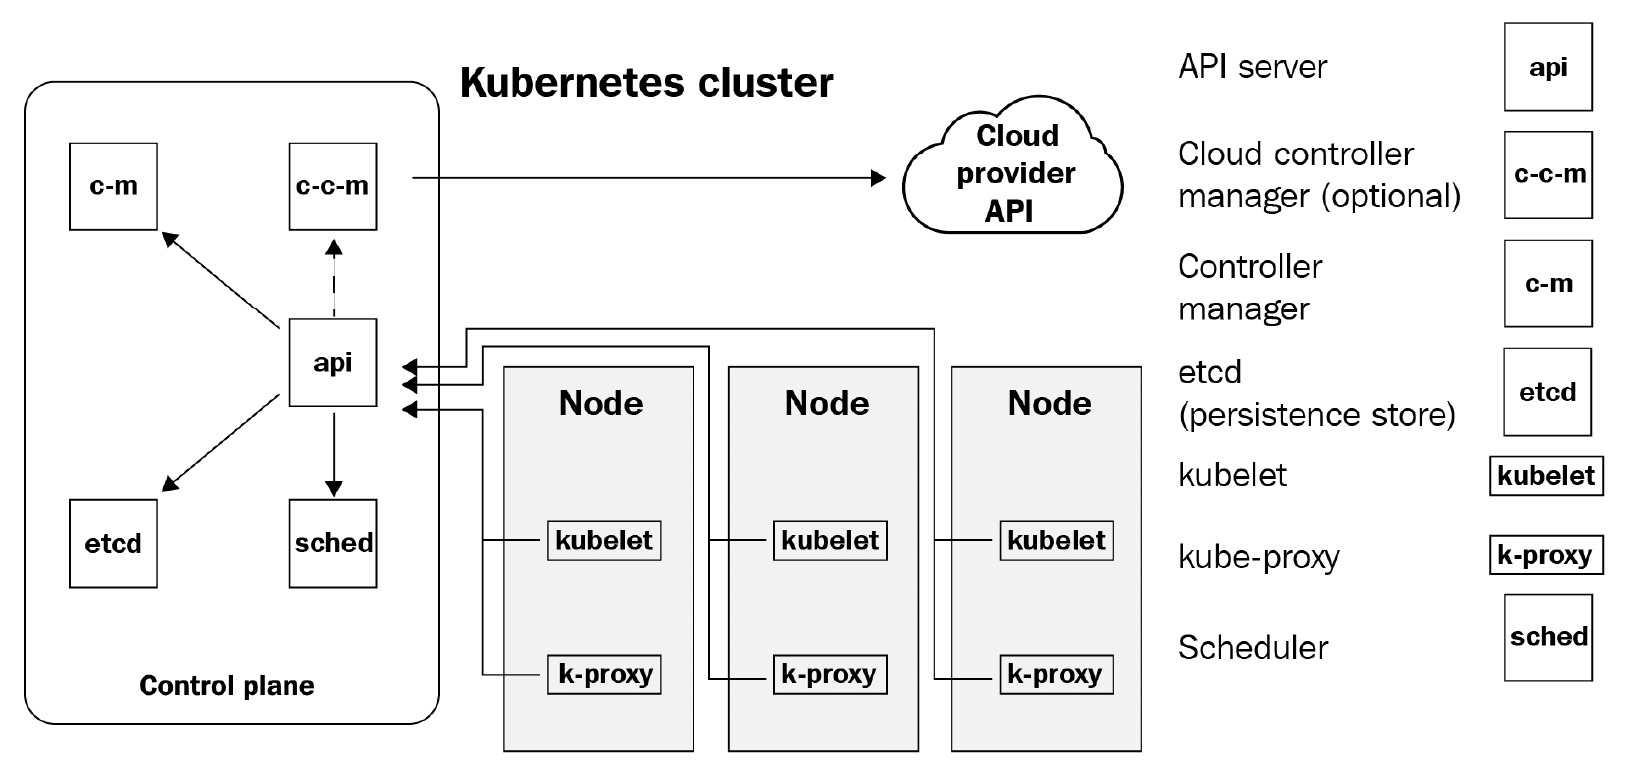

**El plano de control consta de los siguientes componentes:**

- Servidor API: 
      Como ya se discutió, la El servidor API expone un conjunto de API para que los actores externos e internos interactúen con Kubernetes. 
      Todas las interacciones con Kubernetes ocurren a través del servidor API, como se ve en la imagen. Si visualiza el clúster de Kubernetes como un barco, el servidor API es el capitán del barco.
      
- Administrador del controlador: 
      Es el oficial ejecutivo del barco y tiene la tarea de garantizar que se sigan las órdenes del capitán en el grupo. 
      Desde una perspectiva técnica, el administrador del controlador lee el estado actual y el estado deseado y realiza todas las acciones necesarias para mover el estado actual al estado deseado. 
      Contiene un conjunto de controladores que interactúan con los componentes de Kubernetes a través del servidor API cuando sea necesario. 
      
      Algunos de estos son los siguientes: 
          A. Controlador de nodo: Observa cuando el nodo se cae y responde interactuando con el programador de Kube a través del servidor de la API de Kube para programar los pods en un nodo en buen estado.
          B. Controlador de replicación: Esto garantiza que exista la cantidad correcta de réplicas de contenedores definidas por los objetos del controlador de replicación en el clúster.
          C. Controlador de puntos finales: Estos ayudan a proporcionar puntos finales a sus contenedores a través de servicios.
          D. Controladores de tokens y cuentas de servicio: Crean cuentas y tokens predeterminados para nuevos espacios de nombres.
      
- Administrador de controladores en la nube: 
      Este es un administrador de controladores opcional que ejecutaría si ejecuta Kubernetes en una nube pública, como AWS, Azure o GCP. 
      El administrador del controlador de la nube interactúa con las API del proveedor de la nube para aprovisionar recursos como discos persistentes y balanceadores de carga que declara en su configuración de Kubernetes.

- etcd: 
      etcd es la bitácora del barco. 
      Ahí es donde existen todos los detalles sobre la configuración esperada. 
      A partir de una perspectiva técnica, este es un almacén de valores clave donde se almacena toda la configuración deseada de Kubernetes. 
      El administrador del controlador se refiere a la información en esta base de datos para realizar cambios en el clúster.

- Programador: 
      Los programadores son el contramaestro del barco. 
      Tienen la tarea de supervisar la carga y descarga de contenedores en el barco. 
      Un programador de Kubernetes programa contenedores en un nodo de trabajo que considera adecuado después de considerar la disponibilidad de recursos para ejecutarlo, la alta disponibilidad de su aplicación y otros aspectos.

- kubelet: 
      Los kubelets son los marineros del barco. 
      Realizan la carga y descarga propiamente dicha de contenedoresde haciendo referencia a un un barco. 
      Un kubelet interactúa con el tiempo de ejecución del contenedor subyacente para ejecutar contenedores según las instrucciones del programador desde una perspectiva técnica. 
      Si bien la mayoría de los componentes de Kubernetes se pueden ejecutar como un contenedor, el kubelet es el único componente que se ejecuta como un servicio systemd. 
      Por lo general, se ejecutan en nodos trabajadores, pero si planean ejecutar los componentes del plano de control como contenedores, el kubelet también se ejecutará en los nodos del plano de control.

- kube-proxy: 
      kube-proxy se ejecuta en cada nodo trabajador y proporciona los componentes para que sus contenedores interactuen con los componentes de la red dentro y fuera de su clúster. 
      Son un componente vital que facilita el concepto de servicio de Kubernetes.

**Bueno, son muchas partes móviles, pero la buena noticia es que hay herramientas disponibles para configurarlo, y aprovisionar un clúster de Kubernetes es muy simple.** 

- Si están ejecutando en una nube pública, está a solo unos clics de distancia y puede usar la interfaz de usuario web o la CLI de su nube para aprovisionarla muy rápidamente. 
- Si tiene una instalación local, pueden usar kubeadm para la configuración. 

Los pasos a este respecto están bien documentados y entendidos, y no será una molestia.

**Para el desarrollo y sus entornos CI/CD, puede usar Minikube o KinD.** 

- Mientras que Minikube es un clúster de Kubernetes de un solo nodo que se ejecuta en su máquina
- KinD puede ejecutar un clúster de Kubernetes de varios nodos ejecutando los nodos como contenedores. 

En ambos casos, todo lo que necesita es una máquina virtual con los recursos necesarios y está listo para comenzar.

**Ahora, iniciemos un clúster de Kubernetes de un solo nodo con Minikube.**

## Instalación de Kubernetes (Minikube y KinD)

**Ahora avancemos e instalemos Kubernetes para su entorno de desarrollo.** 
- Primero comenzaremos con Minikube para que pueda comenzar rápidamente. Luego usaremos KinD.

### Instalación de Minikube

**Instalaremos Minikube.**

- Primero instalaremos kubectl. 

Como se describí anteriormente, kubectl es la utilidad de línea de comandos que interactúa con el servidor API de Kubernetes. Usaremos kubectl algunas veces.

**Para descargar la última versión de kubectl, ejecutemos**



In [ ]:

$ curl -LO "https://storage.googleapis.com/kubernetes-release/\
release/$(curl -s https://storage.googleapis.com/kubernetes-\
release/release/stable.txt)/bin/linux/amd64/kubectl"


**También es posible que deseen descargar una versión específica en kubectl.**



In [ ]:

$ curl -LO https://storage.googleapis.com/kubernetes-release/\ release/v<kubectl_version>/bin/linux/amd64/kubectl


Nos quedaremos con la última versión por ahora. Y avancemos y hagamos que el binario sea ejecutable y luego lo movemos a cualquier directorio en nuestro sistema PATH:

In [ ]:

$ chmod +x ./kubectl
$ sudo mv kubectl /usr/local/bin/
$ sudo ln -s /usr/local/bin/kubectl /usr/bin/kubectl  ["l" Creamos la referencia para enlace simbolico, y "s" crea una instancia dura]



**Ahora, verifiquemos si kubectl se instaló correctamente.**

In [ ]:

$ kubectl version --client

================

yumkimil@ubuntu:~$ kubectl version -oyaml --client
clientVersion:
  buildDate: "2023-01-18T15:58:16Z"
  compiler: gc
  gitCommit: 8f94681cd294aa8cfd3407b8191f6c70214973a4
  gitTreeState: clean
  gitVersion: v1.26.1
  goVersion: go1.19.5
  major: "1"
  minor: "26"
  platform: linux/arm64
kustomizeVersion: v4.5.7



**Como kubectl se instaló correctamente, ahora descargaremos el binario minikube y luego lo moveremos a la ruta de su sistema**


$ curl -Lo minikube https://storage.googleapis.com/minikube/\
releases/latest/minikube-linux-amd64
$ chmod +x minikube
$ sudo mv minikube /usr/local/bin/
$ sudo ln -s /usr/local/bin/minikube /usr/bin/minikube


**Ahora, instalemoslos paquetes requeridos por Minikube para funcionar correctamente.**

In [ ]:

$ sudo apt-get install -y conntrack


**También debemos proporcionar los permisos apropiados al directorio que se usará para almacenar archivos de Minikube.**



$ mkdir .minikube
$ sudo chown -R $USER $HOME/.minikube
$ chmod -R u+wrx $HOME/.minikube
$ mkdir .kube
$ sudo chown -R $USER $HOME/.kube
$ cd .kube && touch config
$ chmod 600 $HOME/.kube/config


**Finalmente, podemos iniciar un clúster de Minikube.**




elmesias@ubuntu:~$ minikube start --driver=docker

😄  minikube v1.28.0 on Ubuntu 18.04
✨  Using the docker driver based on existing profile
👍  Starting control plane node minikube in cluster minikube
🚜  Pulling base image ...
🏃  Updating the running docker "minikube" container ...
🐳  Preparing Kubernetes v1.25.3 on Docker 20.10.20 ...
🔎  Verifying Kubernetes components...
    ▪ Using image gcr.io/k8s-minikube/storage-provisioner:v5
🌟  Enabled addons: default-storageclass, storage-provisioner
🏄  Done! kubectl is now configured to use "minikube" cluster and "default" namespace by default


Falla de ejemplo debido a que no existe archivo d configuración. Se soluciona creando el fichero "config".

**minikube start --driver=docker**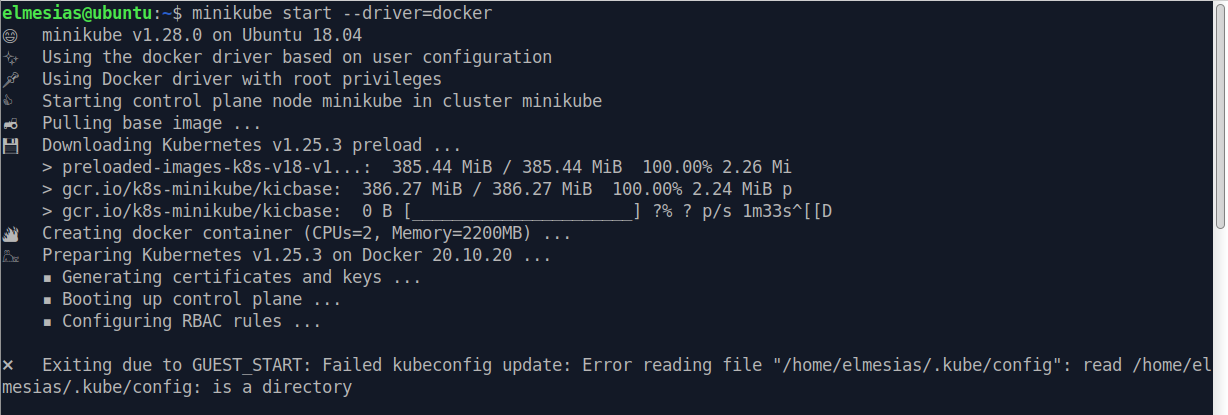

**Como Minikube ahora está en funcionamiento, usaremos la utilidad de línea de comandos kubectl para interactuar con el servidor API de Kube para administrar los recursos de Kubernetes.** 

Los comandos de kubectl tienen una estructura estándar y se explican por sí mismos en la mayoría de los casos.

    kubectl <verb> <resource type> <resource name> [--flags]

Dónde:

- verb: Acción a realizar, me gusta, obtener, aplicar, eliminar, enumerar, parchear, ejecutar, etc.

- resource type: El recurso de Kubernetes para administrar, como nodo, pod, implementación, servicio, etc.

- resource name: El nombre del recurso a administrar.

**Ahora usemos kubectl para obtener nodos y verificar si nuestro clúster está listo para ejecutar nuestros contenedores.**



In [ ]:

elmesias@ubuntu:~$ kubectl get nodes
    
NAME       STATUS   ROLES           AGE    VERSION
minikube   Ready    control-plane   9m1s   v1.25.3


**Y podemos ver que es un solo nodo, Clúster de Kubernetes ejecuta la versión v1.25.3 . ¡Kubernetes ya está funcionando!**

- Esta configuración es excelente para máquinas de desarrollo donde los desarrolladores desean implementar y probar un solo componente en el que están trabajando. 

**Sin embargo, para simular un entorno real, especialmente dentro de una canalización de CI/CD, Minikube tiene sus limitaciones.** 

- Si bien Minikube admite varios nodos, sigue siendo una característica experimental que no se recomienda en las canalizaciones de producción o CI/CD.

**Para detener el clúster de Minikube y eliminarlo de la máquina, hacemos lo siguiente**



In [ ]:

elmesias@ubuntu:~$ minikube stop
    
✋  Stopping node "minikube"  ...
🛑  Powering off "minikube" via SSH ...
🛑  1 node stopped.


**Como eliminamos Minikube, veamos una herramienta interesante para crear un clúster de Kubernetes de múltiples nodos.**



### KinD
**Kubernetes en Docker o KinD, en definitiva, nos permite ejecutar un clúster de Kubernetes de múltiples nodos en un solo servidor que ejecuta Docker.** 

**Entendemos que un clúster de Kubernetes de múltiples nodos requiere múltiples máquinas para ejecutarse, pero ¿cómo podemos ejecutar un clúster de Kubernetes de múltiples nodos en un solo servidor?**

>KinD usa un contenedor Docker como un nodo de Kubernetes. Entonces, si necesitamos un clúster de Kubernetes de cuatro nodos, KinD activará cuatro contenedores que se comportan como cuatro nodos de Kubernetes. Es tan simple como eso.

**Si bien se necesita Docker para ejecutar KinD, KinD internamente usa containerd como tiempo de ejecución del contenedor en lugar de Docker.** 
- Containerd implementa la interfaz de tiempo de ejecución del contenedor y, por lo tanto, Kubernetes no requiere ningún componente especializado, como por ejemplo, dockershim, para interactuar con él. 

**Como KinD admite un clúster de Kubernetes de múltiples nodos, podemos usarlo para actividades de desarrollo y también en canalizaciones de CI/CD.** 

- De hecho, KinD redefine las canalizaciones de CI/CD, ya que no necesita un entorno de Kubernetes estático para probar su compilación. 
- KinD se inicia rápidamente y, por lo tanto, puede integrar el arranque del clúster de KinD, ejecutar y probar las compilaciones de su contenedor dentro del clúster y luego destruirlo todo dentro de su canalización de CI/CD. 
- Brinda a los equipos de desarrollo un inmenso poder y velocidad.

### Importante

**Nunca usen KinD en producción.** 
- Las implementaciones de Docker en Docker no son muy seguras y, por lo tanto, los clústeres de KinD no deberían existir más allá de sus entornos de desarrollo y canalizaciones de CI/CD.

**Iniciar KinD está a solo unos comandos de distancia.** 

Primero debemos descargar KinD, hacerlo ejecutable y luego moverlo al directorio predeterminado.

In [ ]:

$ curl -Lo kind https://kind.sigs.k8s.io/dl/v0.9.0/kind-linux-\
amd64
$ chmod +x kind
$ sudo mv kind /usr/local/bin/kind

======= O la nueva version =======

curl -Lo ./kind https://kind.sigs.k8s.io/dl/v0.17.0/kind-linux-arm64
chmod +x ./kind
sudo mv ./kind /usr/local/bin/kind


Para verificar si KinD está instalado, podemos ejecutar el siguiente comando:



In [ ]:

elmesias@ubuntu:~$ kind version
kind v0.9.0 go1.15.2 linux/amd64


**Ahora, iniciemos un clúster KinD de varios nodos.** 

Primero necesitamos crear un archivo de configurción KinD. 

>El archivo config KinD es un archivo yaml simple donde pueden declarar qué tipo de configuración quieren para cada nodo.

**Agreguemos una configuración para arrancar un solo plano de control y tres clústeres de nodos trabajadores.**


$ vim kind-config.yaml

kind: Cluster
apiVersion: kind.x-k8s.io/v1alpha4
nodes:
- role: control-plane
- role: worker
- role: worker
- role: worker


**También puedes tener una Configuración de alta disponibilidad con varios planos de control utilizando varios elementos de nodo con la función de plano de control.** 

Por ahora, sigamos con un solo plano de control, configuración de tres nodos de trabajo.

**Para iniciar el clúster KinD con la configuración anterior, hagamos lo siguiente**

In [ ]:


elmesias@ubuntu:~/Documents/Docker DevOps/kubernetes$ kind version
kind v0.9.0 go1.15.2 linux/amd64

elmesias@ubuntu:~/Documents/Docker DevOps/kubernetes$ kind create cluster --config kind-config.yaml 
Creating cluster "kind" ...
 ✓ Ensuring node image (kindest/node:v1.19.1) 🖼 
 ✓ Preparing nodes 📦 📦 📦 📦  
 ✓ Writing configuration 📜 
 ✓ Starting control-plane 🕹️ 
 ✓ Installing CNI 🔌 
 ✓ Installing StorageClass 💾 
 ✓ Joining worker nodes 🚜 
Set kubectl context to "kind-kind"
You can now use your cluster with:

kubectl cluster-info --context kind-kind

Have a nice day! 👋


**Y nuestro clúster KinD está en funcionamiento.** 

Verifiquemos si es asi.



In [ ]:

$ kubectl cluster-info --context kind-kind


Hagamos ahora una lista de los nodos para ver con certeza.



In [ ]:

elmesias@ubuntu:~/Documents/Docker DevOps/kubernetes$ kubectl get nodes
    
NAME                 STATUS     ROLES    AGE     VERSION
kind-control-plane   NotReady   master   5m9s    v1.19.1
kind-worker          NotReady   <none>   4m30s   v1.19.1
kind-worker2         NotReady   <none>   4m30s   v1.19.1
kind-worker3         NotReady   <none>   4m30s   v1.19.1


=================
En la nueva maquina, se los estados estan listos sin problema: (Sin Flannel pod network)
    
yumkimil@ubuntu:~/Downloads/kubernetes$ kubectl get nodes
    
NAME                 STATUS   ROLES           AGE     VERSION
kind-control-plane   Ready    control-plane   2m34s   v1.25.3
kind-worker          Ready    <none>          2m10s   v1.25.3
kind-worker2         Ready    <none>          2m10s   v1.25.3
kind-worker3         Ready    <none>          2m10s   v1.25.3



Resolví esto instalando un complemento de red Pod, utilicé Flannel pod network, que es una red superpuesta muy simple que satisface los requisitos de kubernetes.

In [ ]:

elmesias@ubuntu:~/Documents/Docker DevOps/kubernetes$ kubectl get nodes
NAME                 STATUS   ROLES    AGE   VERSION
kind-control-plane   Ready    master   26m   v1.19.1
kind-worker          Ready    <none>   25m   v1.19.1
kind-worker2         Ready    <none>   25m   v1.19.1
kind-worker3         Ready    <none>   25m   v1.19.1


**Y vemos que hay cuatro nodos en el clúster: un plano de control y tres trabajadores.** 

Como el clúster ahora está en funcionamiento, profundicemos en Kubernetes y veamos algunos de los recursos de Kubernetes más utilizados.



## Descripción de los pods de Kubernetes
**Una cápsula de Kubernetes forma el componente básico de una aplicación de Kubernetes.** 

Un pod contiene uno o más contenedores, y todos los contenedores dentro de un pod siempre se programan en el mismo host. 
- Por lo general, hay un solo contenedor dentro de un pod, pero hay casos de uso en los que es posible que desee programar varios contenedores en un solo pod.

**Toma un tiempo digerir por qué Kubernetes comenzó con el concepto de pod en lugar de usar contenedores, pero hay razones para eso, y lo apreciarán a medida que adquiera más experiencia con la herramienta.** 

Por ahora, veamos un ejemplo simple de un pod y cómo programarlo en Kubernetes.

### Ejecutando un pod

Comenzaremos ejecutando un contenedor NGINX en un pod usando comandos imperativos simples. Luego veremos cómo podemos hacerlo de manera declarativa.

**Para acceder a los recursos de esta sección, ingresen a la ubicación del archivo.**

In [ ]:

$ cd /kubernetes/pod/


Para ejecutar un pod con un solo contenedor NGINX, ejecute el siguiente comando:


elmesias@ubuntu:~/Documents/Docker DevOps/kubernetes/pod$ kubectl run nginx --image=nginx

pod/nginx created


Para verificar si el pod se está ejecutando, ejecute el siguiente comando:



In [ ]:

elmesias@ubuntu:~/Documents/Docker DevOps/kubernetes/pod$ kubectl get pod
NAME    READY   STATUS    RESTARTS   AGE
nginx   0/1     Pending   0          24s

================

yumkimil@ubuntu:~$ kubectl get pod
NAME    READY   STATUS    RESTARTS       AGE
nginx   1/1     Running   4 (118m ago)   24h

================

$ kubectl get pods -o wide

AME      READY   STATUS    RESTARTS   AGE    IP           NODE           NOMINATED NODE   READINESS GATES
nginx     1/1     Running   0          24m    10.244.1.4   kind-worker    <none>           <none>


**Como vemos, el pod ahora se está ejecutando.**

El comando kubectl run era la forma imperativa de crear pods, pero hay otra forma de interactuar con Kubernetes: mediante el uso de manifiestos declarativos. 

>Los manifiestos de Kubernetes son archivos YAML o JSON que puede usar para declarar la configuración deseada en lugar de decirle todo a Kubernetes a través de una línea de comandos. El método es similar a docker-compose.

**Tip Pro.**

Utilice siempre el método declarativo para crear recursos de Kubernetes en entornos de ensayo y producción. Le permiten almacenar y versionar su configuración de Kubernetes en una herramienta de administración de código fuente como Git y habilitar GitOps. 

**Veamos un ejemplo de manifiesto de pod nginx-pod.yaml:**

In [ ]:

apiVersion: v1
kind: Pod
metadata:
  labels:
    run: nginx
  name: nginx
spec:
  containers:
  - image: nginx
    imagePullPolicy: Always
    name: nginx
    resources:
      limits:
        memory: "200Mi"
        cpu: "200m"
      requests:
        memory: "100Mi"
        cpu: "100m"
  restartPolicy: Always
    

**Entendamos**

- apiVersion: 
      Esto define la versión del recurso que estamos tratando de definir. En este caso, como es un pod y es un recurso de disponibilidad general (GA), la versión que vamos a usar es v1.
      
- kind: 
      Esto define el tipo de recurso que queremos crear, un pod en este caso.

- metadata: 
      La sección de metadatos define el nombre y las etiquetas que rodean este recurso. 
      Ayuda a identificar de forma única el recurso, así como a agrupar múltiples recursos mediante etiquetas.

- spec: 
      Esta es la principal sección donde definimos las especificaciones reales para el recurso.

- spec.containers: 
      Esta sección define uno o más contenedores que forman el pod.

- spec.containers.name: 
      El nombre del contenedor, nginx-container en este caso.

- spec.containers.image: 
      La imagen del contenedor, nginx en este caso.

- spec.containers.imagePullPolicy: 
      Si se establece en Always, Kubernetes siempre extrae la imagen del registro. 
      Si se establece en IfNotPresent, Kubernetes extrae la imagen solo si la imagen no se encuentra en el nodo donde está programado el pod. 
      Si se establece en Never, Kubernetes nunca intentará extraer imágenes del registro y dependerá completamente de las imágenes locales.

- spec.containers.resources: 
      Define las solicitudes de recursos y los límites.

- spec.containers.resources.limit: 
      Define los límites de recursos. 
      Esta es la cantidad máxima de recursos que el pod puede asignar y, si el consumo de recursos aumenta más allá, el pod se expulsa.

- spec.containers.resources.limit.memory: 
      Define el límite de memoria.

- spec.containers.resources.limit.cpu: 
      Define el límite de CPU.

- spec.containers.resources.requests: 
      Define las solicitudes de recursos. 
      Esta es la cantidad mínima de recursos que el pod solicitaría durante la programación y no se programará en un nodo que no pueda asignarlo.

- spec.containers.resources.requests.memory: 
      Define la cantidad de memoria a solicitar.

- spec.containers.resources.requests.cpu: 
      Define la cantidad de núcleos de CPU que se solicitarán.

- spec.restartPolicy: 
      Define la política de reinicio de los contenedores: Always, OnFailureo Never. Esto es similar a la política de reinicio en Docker.

**Hay otras configuraciones en el manifiesto del pod, pero con estas esta perfecto para iniciar.**

### Consejos importantes

**Establézca imagePullPolicy en IfNotPresent a menos que tenga una razón de peso para usar Always o Never.** 

Eso asegurará que sus contenedores se inicien rápidamente y que no descargue imágenes innecesariamente.

**Utilice siempre las solicitudes y los límites de recursos al programar los pods.** 

- Esto garantiza que su pod esté programado en un nodo apropiado y no agote los recursos existentes. 

También puede aplicar una política de recursos predeterminada a nivel de clúster para asegurarse de que sus desarrolladores no causen ningún daño si se pierden esta sección por algún motivo.

Para aplicar el manifiesto, hacemos lo siguiente.



In [ ]:

$ kubectl apply -f nginx-pod.yaml


**El pod está completamente fuera de los límites del host.** 

Se ejecuta dentro de la red de contenedores y, de forma predeterminada, Kubernetes no permite que ningún pod se exponga a la red del host a menos que queramos exponerlo explícitamente.

Hay dos formas de acceder al pod: usar el reenvío de puertos con kubectl port-forward o exponer el pod a través de un recurso Service.

### Usar el reenvío de puertos

Antes de entrar en el lado del servicio de las cosas, veamos cómo usar la opción port-forward.

**Para exponer el pod mediante el reenvío de puertos, hacemos lo siguiente**

In [ ]:

$ kubectl port-forward nginx 8080:80
    

**Y el indicador está atascado en esto.** 

- Esto significa que ha abierto una sesión de reenvío de puertos y está escuchando en el puerto 8080. 
- Reenviará automáticamente la solicitud que reciba en el puerto 8080 al puerto NGINX 80.

**Abra una sesión de terminal duplicada y luego hagamos curl a la dirección:**



In [ ]:

$ curl 127.0.0.1:8080
    

Podemos ver que está funcionando cuando obtenemos la respuesta NGINX predeterminada.

**Ahora, algunas cosas para recordar:**

Cuando usamos el reenvío de puerto HTTP, estamos reenviando solicitudes desde la máquina cliente que se ejecuta de kubectl al pod, algo similar al siguiente diagrama:

**Reenvío del puerto de kubectl**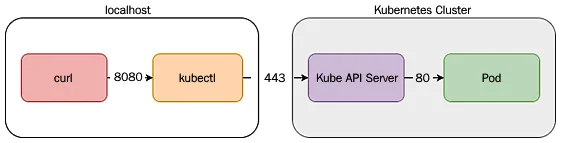

Cuando ejecuta un kubectl port-forward, el cliente kubectl abre un túnel TCP a través del servidor de la API de Kube, y el servidor de la API de Kube reenvía la conexión al pod correcto. 
- Como la conexión entre el kubectlcliente y el servidor API está encriptada, es una forma muy segura de acceder a su pod, pero manténgase alerta antes de decidir usar el kubectl port-forward para exponer los pods al mundo exterior.

**Existen casos de uso particulares para usar kubectl port-forward.**

- Para solucionar problemas de cualquier pod que se comporte mal.
- Para acceder a un servicio interno de Kubernetes, como el panel de control de Kubernetes. Es entonces cuando no desea exponer el servicio al mundo externo, sino que solo permite que los administradores y usuarios de Kubernetes inicien sesión en el tablero. Se supone que solo estos usuarios tendrán acceso al clúster a través de kubectl.

Para cualquier otra cosa, debe usar el recurdo Service para exponer su pod, interna o externamente. 


### Solución de problemas de los módulos
Como podemos buscar registros desde uncontainer usando docker logs, podemos buscar registros desde un contenedor dentro de un pod de Kubernetes usando el kubectl logscomando. Si se ejecuta más de un contenedor dentro del pod, podemos especificar el nombre del contenedor usando la -cbandera.

Para acceder a los registros del contenedor, ejecute el siguiente comando:



In [ ]:

$ kubectl logs nginx -c nginx


Como el pod ejecuta un solo contenedor, no necesitamos especificar el -cindicador, por lo que también puede usar el siguiente comando:



In [ ]:

$ kubectl logs nginx


Puede haber instancias en las que desee obtener un shell para un contenedor en ejecución y solucionar lo que sucede dentro de eso. Usamos docker execpara eso en el mundo Docker. Del mismo modo, podemos usar kubectl execpara eso dentro de Kubernetes.

Ejecute el siguiente comando para abrir una sesión de shell con el contenedor:



In [ ]:

$ kubectl exec -it nginx -- /bin/bash
root@nginx:/# cd /etc/nginx/ && ls
conf.d  fastcgi_params  koi-utf  koi-win  mime.types  modules  nginx.conf  scgi_params  uwsgi_params  win-utf
root@nginx:/etc/nginx# exit
    

Incluso puedes corrercomandos específicos sin abrir una sesión de shell. Por ejemplo, podemos realizar la operación anterior con una sola línea, algo como lo siguiente:

In [ ]:

$ kubectl exec nginx -- ls /etc/nginx
conf.d  fastcgi_params  koi-utf  koi-win  mime.types  modules  nginx.conf  scgi_params  uwsgi_params  win-utf


kubectl execes un comando importante que nos ayuda a solucionar problemas de contenedores.



### Consejo

Si modifica archivos o descarga paquetes dentro del contenedor en el execmodo, persistirán hasta que el pod actual esté activo. Una vez que el pod se haya ido, perderá todos los cambios. Por lo tanto, no es una gran manera de solucionar problemas. Solo debe diagnosticar problemas usando exec, hornear los cambios correctos en una nueva imagen y luego volver a implementarla.

Cuando analizamos los contenedores sin distribución en el capítulo anterior, no permitían execel ingreso al contenedor por razones de seguridad. Hay imágenes de depuración disponibles para distroless que le permitirán abrir una sesión de shell para solucionar problemas si lo desea.

### Consejo

De manera predeterminada, un contenedor se ejecuta como usuario raíz si no ha especificado el usuario dentro del Dockerfile mientras crea la imagen. Puede establecer un runAsUseratributo dentro del contexto de seguridad de su pod si desea ejecutar su pod como un usuario específico, pero esto no es lo ideal. La mejor práctica es hornear al usuario dentro de la imagen del contenedor.

hemos discutidosolucionar problemas de ejecución de contenedores, pero ¿qué sucede si los contenedores no se inician por algún motivo?

Veamos el siguiente ejemplo, dentro del cual, colocaremos una imagen incorrecta.



In [ ]:

$ kubectl run nginx-1 --image=nginx-1


Ahora, intentemos obtener el pod y ver por nosotros mismos:

In [ ]:

$ kubectl get pod nginx-1


¡Ups! Hay algún error ahora, y el estado es ImagePullBackOff. Bueno, parece que hay algún problema con la imagen. Si bien entendemos que el problema está relacionado con la imagen, queremos comprender el problema real, por lo que para obtener más información al respecto, podemos describir el pod con el siguiente comando:

In [ ]:

$ kubectl describe pod nginx-1


Ahora, esto nos brinda una gran cantidad de información sobre el pod, y si observa la sección de eventos, encontrará una línea específica que nos dice qué está mal con el pod:

    Warning  Failed     60s (x4 over 2m43s)  kubelet            Failed to pull image "nginx-1": rpc error: code = Unknown desc = failed to pull and unpack image "docker.io/library/nginx-1:latest": failed to resolve reference "docker.io/library/nginx-1:latest": pull access denied, repository does not exist or may require authorization: server message: insufficient_scope: authorization failed

Entonces, este nos está diciendo queo el repositorio no existe, o el repositorio existe pero es privado y, por lo tanto, la autorización falló.

**Tip Pro.**

Puede usar kubectl describepara la mayoría de los recursos de Kubernetes, y debería ser el primer comando que debe usar al solucionar problemas.

Entonces, como todos sabemos que la imagen no existe, cambiemos la imagen por una válida. Para hacer eso, tenemos que eliminar el pod y luego volver a crearlo con la imagen correcta.

Para eliminar el pod, ejecute el siguiente comando:

In [ ]:

$ kubectl delete pod nginx-1


Entonces, el siguiente paso sería recrear el pod con la imagen correcta.

Para volver a crear el pod, ejecute el siguiente comando:



In [ ]:

$ kubectl run nginx-1 --image=nginx


Ahora, obtengamos el pod, y debería ejecutarse:

In [ ]:

$ kubectl get pod nginx-1


Y el pod ahora se está ejecutando ya que hemos solucionado el problema de la imagen.

Hasta ahora, solo hemos logrado ejecutar contenedores usando pods, pero los pods son recursos muy poderosos y también lo ayudan a administrar contenedores. Los pods de Kubernetes proporcionan un montón de sondas para garantizar la confiabilidad de su aplicación. Echemos un vistazo a eso en la siguiente sección.



### Asegurar la confiabilidad de la cápsula
hemos hablado de saludcomprueba en el capítulo sobre Docker, y también mencioné que no debe usarlo en el nivel de Docker y, en su lugar, usar los proporcionados por su orquestador de contenedores. Kubernetes proporciona tres sondas para monitorear el estado de su pod: la sonda de inicio , la sonda de actividad y la sonda de preparación .

El siguiente diagramarepresenta las tres sondas gráficamente:

**Sondeos de Kubernetes**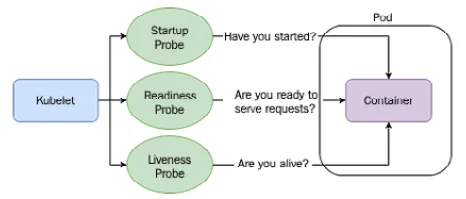

Veamos ahoracada uno a su vez y entender cómo y cuándo usarlos:

#### Sonda de inicio
Kubernetes utiliza el iniciosondeos para comprobar si la aplicación se ha iniciado. Puede usar sondas de inicio en aplicaciones que se inician lentamente o no sabecuánto tiempo puede tardar en empezar. Mientras la sonda de inicio está activa, deshabilita otras sondas para no interferir en su funcionamiento. Como la aplicación no se ha iniciado hasta que la sonda de inicio lo informa, no tiene sentido tener otras sondas activas.

#### Sonda de preparación
Las sondas de preparación se utilizan para determinarsi un contenedor está listo para atender solicitudes. Se diferencian de las sondas de inicio porque, a diferencia de la sonda de inicio que solo comprueba si la aplicación se ha iniciado, la sonda de preparación garantiza que el contenedor pueda comenzar a procesar solicitudes. Un pod está listo cuando todos los contenedores del pod están listos. Las pruebas de preparación aseguran que no se envíe tráfico a un pod si el pod no está listo. Por lo tanto, permitepara una mejor experiencia de usuario.

#### Sonda de vida
Las sondas de actividad se utilizan paracomprobar si un contenedor está funcionando y en buen estado. La sonda comprueba periódicamente el estado de los contenedores. Si se encuentra que un contenedor no está en buen estado, la sonda de actividad matará el contenedor. Si configuró el restartPolicyde su pod en Alwayso OnFailure, Kubernetes reiniciará el contenedor. Por lo tanto, mejora la confiabilidad del servicio al detectar interbloqueos y garantizar que los contenedores se estén ejecutando en lugar de solo informar que se están ejecutando.

Ahora, echemos un vistazo a un ejemplo para comprender mejor las sondas.



#### Sondas en acción
Mejoremos el último manifiestoy agregue algunas sondas a eso para crear el siguiente nginx-probe.yamlarchivo de manifiesto:



In [ ]:

    ...
    startupProbe:
      exec:
        command:
        - cat
        - /usr/share/nginx/html/index.html
      failureThreshold: 30
      periodSeconds: 10
    readinessProbe:
      httpGet:
        path: /
        port: 80
      initialDelaySeconds: 5
      periodSeconds: 5
    livenessProbe:
      httpGet:
        path: /
        port: 80
      initialDelaySeconds: 5
      periodSeconds: 3
  restartPolicy: Always
    

El archivo de manifiestocontiene las tres sondas:

- La sonda de inicio comprueba si el /usr/share/nginx/html/index.htmlarchivo existe. Continuará revisándolo 30 veces con un intervalo de 10 segundos hasta que uno de ellos tenga éxito. Una vez que detecta el archivo, la sonda de inicio dejará de sondear más.
- La sonda de preparación comprueba si hay un agente de escucha en el puerto 80 y responde con HTTP 2xx – 3xx on path /. Inicialmente espera 5 segundos y luego verifica el pod cada 5 segundos. Si obtiene una 2xx – 3xxrespuesta, informará que el contenedor está listo y aceptará las solicitudes.
- La sonda de actividad comprueba si el pod responde con HTTP 2xx – 3xxel puerto 80y path /. Inicialmente espera 5 segundos y sondea el contenedor cada 3 segundos. Supongamos, durante una verificación, que encuentra que el pod no responde por failureThresholdmomentos (el valor predeterminado es 3). En ese caso, eliminará el contenedor y el kubelet tomará las medidas apropiadas según el pod restartPolicy.
- Apliquemos el archivo YAML usando el siguiente comando y veamos qué obtenemos:

In [ ]:

$ kubectl apply -f nginx-probe.yaml


Ahora, veamos cómo los pods cobran vida usando el siguiente comando:



In [ ]:

$ kubectl get pod -w

NAME    READY   STATUS              RESTARTS   AGE
nginx   0/1     ContainerCreating   0          8s
nginx   0/1     Running             0          14s
nginx   1/1     Running             0          23s


Como vemos, el pod está listo rápidamente desde el estado de ejecución. Se tarda aproximadamente 10 segundos para que eso suceda. Esto se debe a que la sonda de preparación se inicia 10 segundos después de que se inició el pod. Luego, la sonda de actividad continúa monitoreando la salud de la cápsula.

Ahora, hagamos algoeso romperá el control de vida. Imagine un escenario en el que alguien coloca un caparazón en el contenedor y elimina algunos archivos importantes de allí. ¿Cómo crees que reaccionará la sonda de vida? Echemos un vistazo.

Eliminemos el archivo /usr/share/nginx/html/index.html del contenedor y luego verifiquemos cómo se comporta el contenedor usando el siguiente comando:

In [ ]:

$ kubectl exec -it nginx -- rm -rf /usr/share/nginx/html/index.html && kubectl get pod nginx -w

NAME    READY   STATUS    RESTARTS      AGE
nginx   1/1     Running   4 (34s ago)   15m
nginx   0/1     Running   5 (1s ago)    15m
nginx   0/1     Running   5 (3s ago)    15m
nginx   1/1     Running   5 (8s ago)    15m



Entonces, mientras observamos el pod, la eliminación inicial se detecta solo después de 10 segundos. Eso es por la sonda de vida. Lo intenta durante 9 segundos, es decir, tres veces periodSeconds, de forma failureThresholdpredeterminada 3, antes de declarar que el pod no está en buen estado y eliminar el contenedor. Tan pronto como elimina el contenedor, el kubelet lo reinicia ya que el pod restartPolicyestá configurado en Always. Luego vemos que se activan las sondas de inicio y preparación, y pronto el módulo está listo.

Por lo tanto, pase lo que pase, sus pods son confiables y funcionarán incluso si una parte de su aplicación es defectuosa.

**Tip Pro.**

El uso de las sondas de preparación y actividad ayudará a proporcionar una mejor experiencia de usuario, ya que no se envían solicitudes a los pods que no están listos para procesar ninguna solicitud. Si su aplicación no responde adecuadamente, reemplazará el contenedor. Si tiene varios pods ejecutándose para atender la solicitud, su servicio es excepcionalmente resistente.

Como discutimos anteriormente, unpod puede contener uno o más contenedores. Veamos algunos de los casos de uso en los que es posible que desee utilizar varios contenedores en lugar de uno.

### Patrones de diseño de contenedores múltiples de pod
**Podemos ejecutar varios contenedores en pods de dos maneras:** 
- Ejecutar un contenedor como contenedor de inicio o ejecutar un contenedor como contenedor auxiliar para el contenedor principal. 

**Exploremos ambos enfoques.**

### Contenedores de inicio
Los contenedores de inicio se ejecutan antes que el contenedor principal arranque y, por lo tanto, podemos usarlos para inicializar su entorno de contenedor antes de que el contenedor principal se haga cargo, por ejemplo.

- Un directorio puede requerir un conjunto particular de propiedad o permisos antes de que desee iniciar su contenedor con el usuario no raíz.
- Es posible que desee clonar un repositorio de Git antes de activar el servidor web.
- Podemos agregar un retraso de inicio.
- Podemos generar una configuración de forma dinámica, como para los contenedores que desean conectarse dinámicamente a algún otro pod del que no es consciente durante el tiempo de compilación, pero que debería serlo durante el tiempo de ejecución.

**Tip Pro**

Utilícemos los **contenedores de inicio** solo como último recurso, ya que dificultan el tiempo de puesta en marcha de nuestros contenedores. Tratemos de poner lista la configuración dentro de la imagen de nuestro contenedor o personalicemosla si es necesario.

**Ahora, hagamos un ejemplo para ver contenedores init en acción.**

Accedemos a los recorsos


In [ ]:

$ cd ~/Downloads/kubernetes/multi-container-pod/init



**Sirvamos el sitio web example.com desde nuestro servidor web nginx**. 

Obtendremos la página web example.com y la guardaremos como index.html en el directorio HTML nginx predeterminado antes empezando nginx_.

**Vamos al archivo de manifiesto nginx-init.yaml**


In [ ]:
...
spec:
  containers:
  - name: nginx-container
    image: nginx
    volumeMounts:
    - mountPath: /usr/share/nginx/html
      name: html-volume
  initContainers:
  - name: init-nginx
    image: busybox:1.28
    command: ['sh', '-c', 'mkdir -p /usr/share/nginx/html && wget -O /usr/share/nginx/html/index.html http://example.com']
    volumeMounts:
    - mountPath: /usr/share/nginx/html
      name: html-volume
  volumes:
  - name: html-volume
    emptyDir: {}
        
        

**Si nos fijamos en la sección de especificaciones del archivo de manifiesto, vemos lo siguiente:**

- **containers**
      Esta sección define uno o más contenedores que forman el pod.
- **containers.name** 
      El nombre del contenedor, nginx-container en este caso.
- **containers.image**
      La imagen del contenedor, nginx en este caso.
- **containers.volumeMounts**
      Esto define una lista de volúmenes que deben montarse en el contenedor. Es similar a los volúmenes.
- **containers.volumeMounts.mountPath**
      Esto define la ruta para montar el volumen, /usr/share/nginx/html en este caso. Compartiremos este volumen con el contenedor de inicio para que cuando el contenedor de inicio descargue el archivo index.html de example.com, este directorio contenga el mismo archivo.
- **containers.volumeMounts.name**
      El nombre del volumen, html-volume en este caso.
- **initContainers** 
      Esta sección define uno o más contenedores de inicio que se ejecutan antes que los contenedores principales.
- **initContainers.name** 
      El nombre del contenedor de inicio, init-nginx en este caso.
- **initContainers.image** 
      La imagen del contenedor de inicio, busybox:1.28 en este caso.
- **initContainers.command** 
      El comando que debe ejecutar el busybox. En este caso, 'mkdir -p /usr/share/nginx/html && wget -O /usr/share/nginx/html/index.html http://example.com 'descargará el contenido de example.com al directorio /usr/share/nginx/html.
- **initContainers.volumeMounts** 
      Montaremos el mismo volumen que definimos en este contenedor nginx-container. Entonces, todo lo que guardemos en este volumen aparecerá automáticamente en formato nginx-container.
- **initContainers.volumeMounts.mountPath** 
      Esto define la ruta para montar el volumen, /usr/share/nginx/html en este caso.
- **initContainers.volumeMounts.name** 
      El nombre del volumen, html-volume en este caso.
- **volumes** 
      Esta sección define uno o más volúmenes asociados con los contenedores del pod.
- **volumes.name** 
      El nombre del volumen, html-volume en este caso.
- **volumes.emptyDir** 
      Esto define un volumen emptyDir. Es similar a un volumen tmpfs en Docker, y por lo tanto, no es persistente y dura solo la vida útil del contenedor.

Entonces, sigamos adelante y apliquemos el manifiesto usando el siguiente comando:

In [ ]:

$ kubectl apply -f nginx-init.yaml


Ahora, a medida que se crea el pod, vamos a mirar el pod y veamos lo que obtenemos si hacemos lo siguiente.

In [ ]:

$ kubectl get pod nginx -w


**Inicialmente, vemos que el nginx pod muestra el estado de Init:0/1.** 

Esto significa que 0 de 1 initContainers han comenzado a inicializarse. 

> Después de un tiempo, vemos que el pod informa el estado – PodInitializing, lo que significa que los contenedores de inicio han comenzado a ejecutarse. Una vez que los contenedores de inicio se han ejecutado correctamente, el pod informa un estado de ejecución.

**Ahora, una vez que el pod comienza a ejecutarse, podemos reenviar el puerto del contenedor 80 al puerto de host 8080 usando el siguiente comando.**

In [ ]:

$ kubectl port-forward nginx 8080:80
    

Abra una terminal duplicada e intente con curl en el host local en el puerto 8080.


In [ ]:

$ curl localhost:8080


**Y vemos el ejemplo de respuesta de dominio de nuestro servidor web.** 

- Esto significa que el contenedor init funcionó perfectamente bien.

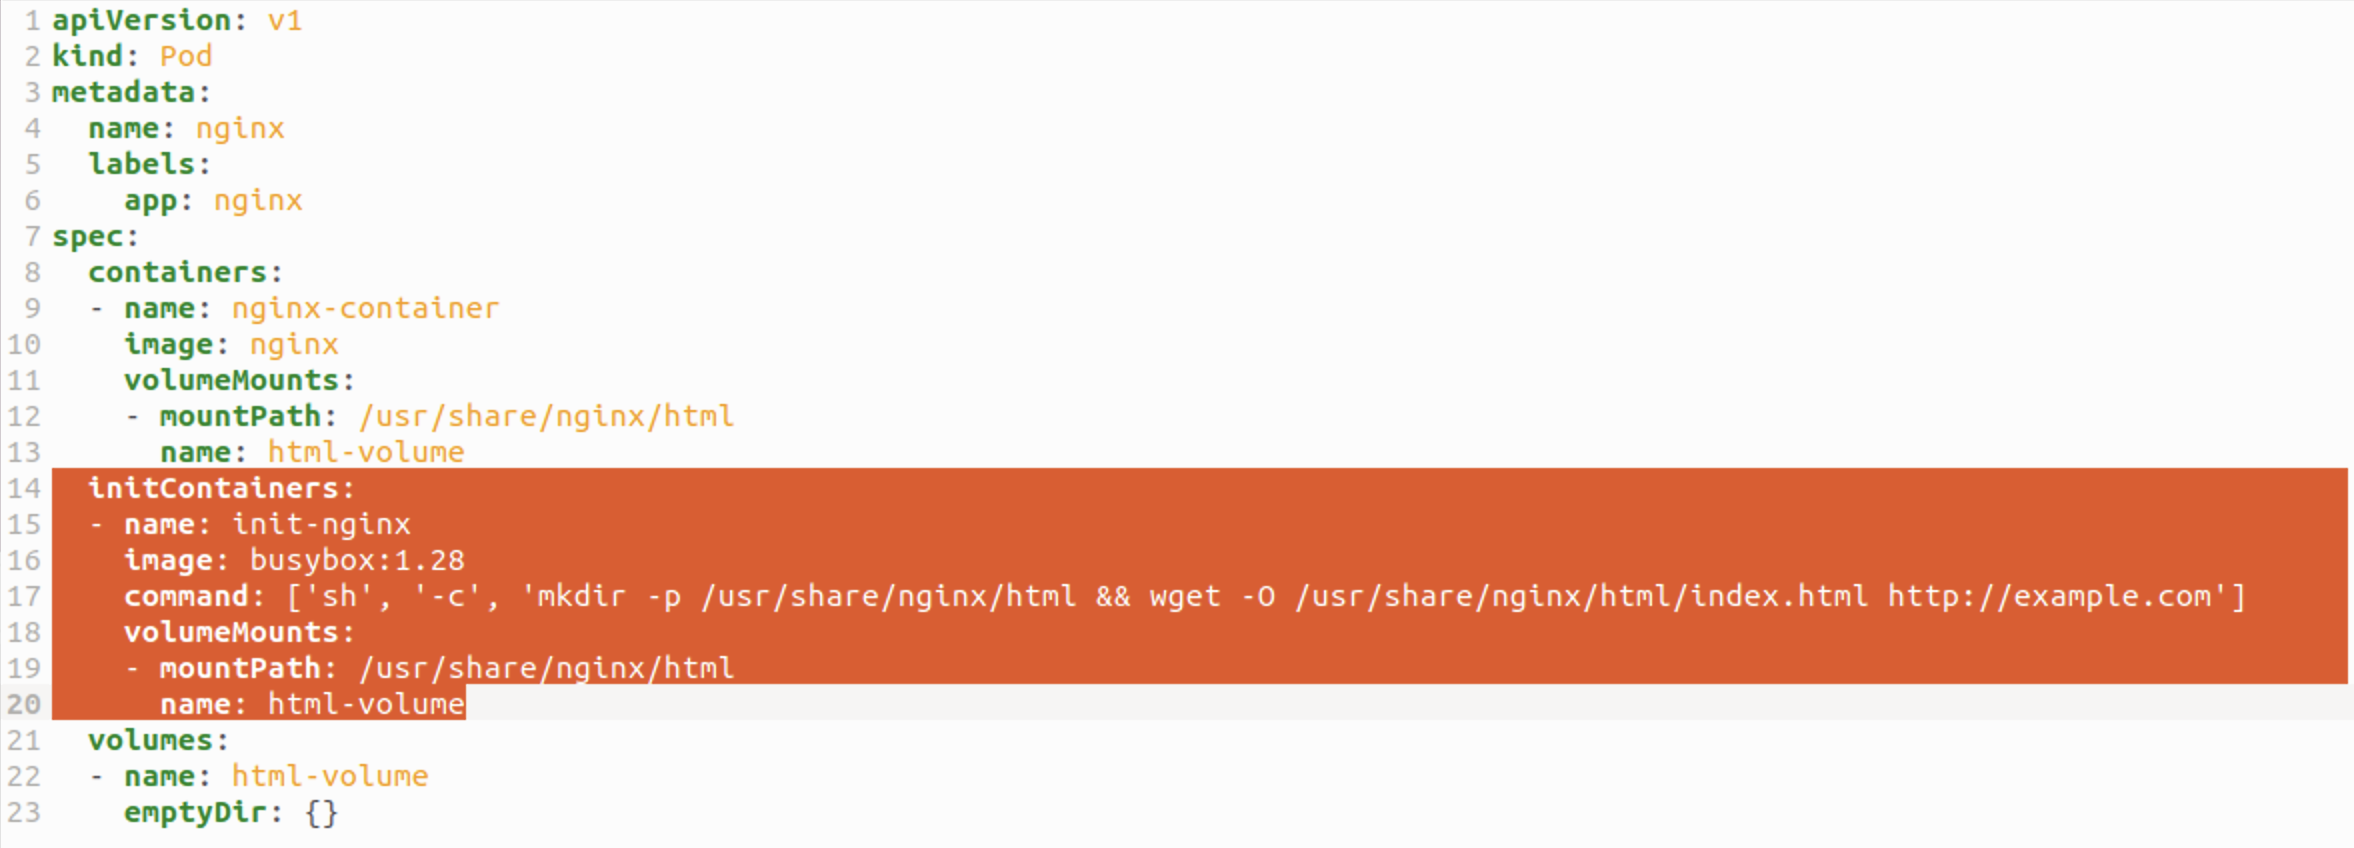

Ahora, entendemos que, el ciclo de vida de los contenedores init termina antes de que comiencen los contenedores primarios, y un pod puede contener uno o más contenedores principales. 

**Por lo tanto, veamos algunos patrones de diseño que podemos usar en el contenedor principal.**

### Patrón de embajador
**El patrón embajador deriva su nombre del embajador, que es un enviado que representa a un país en el extranjero.** 

- También puede pensar en un embajador como un representante de una aplicación en particular. 

**Digamos, por ejemplo, que ha migrado una de sus aplicaciones Python Flask existentes a contenedores, y uno de sus contenedores necesita comunicarse con una base de datos Redis.** 

La base de datos siempre existió en el host local de su sistema. Por lo tanto, los detalles de conexión de la base de datos dentro de su aplicación contienen localhost en todas partes.

**Ahora, hay dos enfoques que podemos tomar.**

- Podemos cambiar la aplicación, codificando y usando mapas de configuración y secretos (más sobre esto más adelante) para inyectar los detalles de conexión de la base de datos en la variable de entorno.
- También podemos seguir usando el código existente y usar un segundo contenedor para actuar como un proxy TCP para la base de datos de Redis. El proxy TCP se vinculará con el mapa de configuración y los secretos y contendrá los detalles de conexión de la base de datos de Redis.

**Tip Pro.**

El patrón embajador ayuda a los desarrolladores a concentrarse en su aplicación sin preocuparse por los detalles de configuración. Considere usarlo si desea desvincular el desarrollo de aplicaciones con la gestión de configuración.

**El segundo enfoque resuelve nuestro problema si deseamos hacer una migración similar.** 

Podemos usar mapas de configuración para definir la configuración específica del entorno sin cambiar el código de la aplicación. 

**El siguiente diagrama muestra el enfoque.**

**Patrón Embajador[Ambassador pattern]**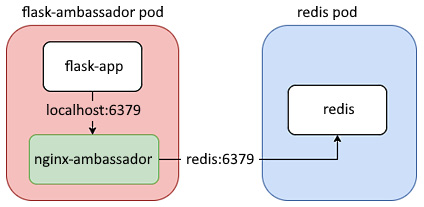

**Antes de profundizar en los tecnicismos, comprendamos qué es un mapa de configuración.**

#### Mapa de configuración
Un mapa de configuración contiene pares clave-valor que podemos usar para varios propósitos, como definir propiedades específicas del entorno o inyectar una variable externa en el inicio del contenedor o durante el tiempo de ejecución.

- La idea del mapa de configuración es desacoplar la aplicación con la configuración y externalizar la configuración a nivel de Kubernetes. 
- Es similar a utilizar un archivo de propiedades de Java, por ejemplo, para definir la configuración específica del entorno.


**Mapas de configuración**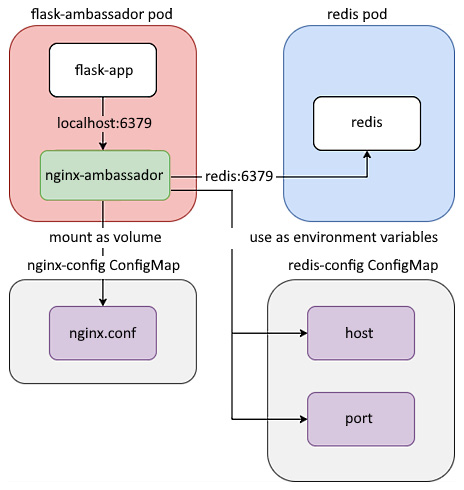

**Usaremos ConfigMap para definir las propiedades de conexión de la base de datos Redis externa dentro del envase embajador.**

### Ejemplo de aplicación
Entonces, sigamos adelante y veamos el código de aplicación para este ejercicio.

**01 | Vamos a crear el archivo app.py con la aplicación Flask.**

In [ ]:

import time
import redis
from flask import Flask
from datetime import datetime


app = Flask(__name__)
cache = redis.Redis(host='localhost', port=6379)

def obtener_ultima_visita():
    try:
        ultima_visita = cache.getset('ultima_visita',str(datetime.now().strftime("%Y-%m-%d, %H:%M:%S")))
        if ultima_visita is None:
            return cache.getset('ultima_visita',str(datetime.now().strftime("%Y-%m-%d, %H:%M:%S")))
        return ultima_visita
    except redis.exceptions.ConnectionError as e:
        raise e
@app.route('/')
def index():
    ultima_visita = str(obtener_ultima_visita().decode('utf-8'))
    return 'WCSO! Visitado el {}.\n'.format(ultima_visita)


**02 | Y el archivo requirements.txt es el siguiente.**

In [ ]:

flask
redis


**03 | También necesitamos crear un Dockerfile, que es el siguiente.**


In [ ]:

FROM python:3.7-alpine
ENV FLASK_APP=app.py
ENV FLASK_RUN_HOST=0.0.0.0
RUN apk add --no-cache gcc musl-dev linux-headers
COPY requirements.txt requirements.txt
RUN pip install -r requirements.txt
EXPOSE 5000
COPY . .
CMD ["flask", "run"]


**04 | Construyamos el contenedor.**



In [ ]:

$ docker build -t <usuario_dockerhub>/flask-redis .


**05 | Empujémoslo a nuestro registro de contenedor.**



In [ ]:

$ docker push <usuario_dockerhub>/flask-redis


**Como habrás notado, el código app.py define el caché como localhost:6379.** 

- Ejecutaremos un contenedor Ambassador(embajador) en localhost:6379. 
- El proxy canalizará la conexión al pod redis que se ejecuta en otro lugar.

**06 | Primero creemos el pod redis**

In [ ]:

$ kubectl run redis --image=redis


**07 | Ahora, expongamos el pod redis a los recursos del clúster a través de un recurso Service.** 

Eso permitirá que cualquier pod dentro del clúster se comunique con el pod redis usando el nombre de host redis. 

Hablaremos sobre los recursos de Kubernetes Service más adelante.

In [ ]:

$ kubectl expose pod redis --port 6379


**Genial, ahora que el pod y el recurso Service están en funcionamiento, trabajemos en el patrón de embajador.**

**08 | Necesitamos definir dos mapas de configuración primero.** 

El primero describe los detalles redis del host y el puerto, y el segundo define el archivo de plantilla nginx.conf para que funcione como un proxy inverso.

Entonces, el archivo **redis-config-map.yaml** se veria algo asi.



In [ ]:

apiVersion: v1
kind: ConfigMap
metadata:
  name: redis-config
data:
  host: "redis"
  port: "6379"
    

El archivo yaml anterior define un mapa de configuración llamado redis-config, que contiene dos propiedades: host y port. Podemos tener varios mapas de configuración, uno para cada entorno.

El archivo **nginx-config-map.yaml** así.

In [ ]:

apiVersion: v1
kind: ConfigMap
metadata:
  name: nginx-config
data:
  nginx.conf: |
    user nginx;
    worker_processes auto;
    error_log /var/log/nginx/error.log;
    pid /run/nginx.pid;
    include /usr/share/nginx/modules/*.conf;
    events {
        worker_connections 1024;
    }
    stream {
        server {
            listen     6379;
            proxy_pass stream_redis_backend;
        }
        upstream stream_redis_backend {
            server REDIS_HOST:REDIS_PORT;
        }
    }
    

**Este mapa de configuración inyecta la plantilla nginx.conf como un valor de mapa de configuración.** 

Podemos montar este archivo en un volumen y luego manipularlo de acuerdo con el entorno. Usaremos un initContainer para inicializar el proxy con la configuración correcta.

**09 | Ahora echemos un vistazo al manifiesto de configuración del pod flask-ambassador.yaml.** 

Hay varias partes de este archivo YAML. 

**Veamos primero la sección de contenedores**



In [ ]:

...
spec:
  containers:
  - name: flask-app
    image: <usuario_dockerhub>/flask-redis
  - name: nginx-ambassador
    image: nginx
    volumeMounts:
    - mountPath: /etc/nginx
      name: nginx-volume
  ...


- Contiene un contenedor llamado **flask-app** que usa la imagen <usuario_dockerhub>/flask-redis que construimos en la sección anterior. 
- El segundo contenedor es el contenedor **nginx-ambassador**; este es el contenedor que actuará como proxy para redis. 
    - Por lo tanto, hemos montado el directorio /etc/nginx en un volumen. 
    - El volumen también se monta en el contenedor de inicio para generar la configuración requerida antes de iniciarse nginx.

**La siguiente es la sección initContainers**



In [ ]:

  initContainers:
  - name: init-nginx
    image: busybox:1.28
    command: ['sh', '-c', 'cp -L /config/nginx.conf /etc/nginx/nginx.conf && sed -i "s/REDIS_HOST/${REDIS_HOST}/g" /etc/nginx/nginx.conf']
    env:
      - name: REDIS_HOST
        valueFrom:
          configMapKeyRef:
            name: redis-config
            key: host
      - name: REDIS_PORT
        valueFrom:
          configMapKeyRef:
            name: redis-config
            key: port
    volumeMounts:
    - mountPath: /etc/nginx
      name: nginx-volume
    - mountPath: /config
      name: config
        

**Define un contenedor busybox – init-nginx.** 

El contenedor necesita generar la configuración del proxy **nginx-ambassador** para comunicarse con Redis y, por lo tanto, hay dos variables de entorno presentes. Ambas variables de entorno se obtienen del mapa de configuración **redis-config**. 

Aparte de eso, también hemos montado el archivo **nginx.conf** desde el mapa de configuración **nginx-config.** 

La sección de comando dentro del contenedor de inicio está usando las variables de entorno para reemplazar los marcadores de posición dentro del archivo **nginx.conf**, y finalmente obtenemos un proxy TCP para el backend de Redis.

En la sección de volúmenes se define como **nginx-volume** un volumen **emptyDir** y el volumen **config** se monta desde **nginx.conf** el presente en el mapa de configuración **nginx-config**.

In [ ]:

  volumes:
  - name: nginx-volume
    emptyDir: {}
  - name: config
    configMap:
      name: nginx-config
      items:
      - key: "nginx.conf"
        path: "nginx.conf"
            

**10 | Entonces, ahora comencemos a aplicar los archivos yaml en pasos.**

Apliquemos ambos mapas de configuración primero.

In [ ]:

$ kubectl apply -f redis-config-map.yaml
$ kubectl apply -f nginx-config-map.yaml


**11 | Apliquemos la configuración del pod.**



In [ ]:

$ kubectl apply -f flask-ambassador.yaml


**12 | Obtenga el pod para ver si la configuración es correcta.**

In [ ]:

$ kubectl get pod/flask-ambassador


**13 | Como el pod se está ejecutando correctamente ahora, reenviemos el puerto 5000 al host local para algunas pruebas.**



In [ ]:

$ kubectl port-forward flask-ambassador 5000:5000
    

**14 | Ahora, abra una terminal duplicada e intente usar el curl localhost:5000**



In [ ]:

$ curl localhost:5000
$ curl localhost:5000
$ curl localhost:5000


**Y como vemos, cada vez que ingresamos a la aplicación curl, obtenemos la hora de la última visita en nuestra pantalla. El patrón embajador está funcionando.**

Ese fue un ejemplo simple del patrón de embajador. Hay configuraciones avanzadas que podemos hacer para agregar un control detallado sobre cómo nuestra aplicación debe interactuar con el mundo exterior. 

Podemos usar el patrón embajador para asegurar el tráfico que se mueve desde nuestros contenedores. También simplifica el desarrollo de aplicaciones para nuestro equipo de desarrollo, ya que no necesitamos preocuparnos por estos matices. Por el contrario, el equipo de operaciones puede usar estos contenedores para administrar su entorno de una mejor manera, sin pisar los dedos de los demás.


**Tip Pro**

Dado que el patrón Ambassador agrega algún tipo de sobrecarga a medida que canaliza las conexiones a través de un proxy, debemos usarlo solo si los beneficios de administración superan el costo adicional en el que incurre debido al contenedor Ambassador.

**Ahora, echemos un vistazo a otro patrón de cápsulas(pods) de varios contenedores: sidecars.**

### Patrón de sidecar

**Los sidecars en un pod son contenedores auxiliares que brindan diferentes funcionalidades no relacionadas con la funcionalidad principal del contenedor principal, pero que en su lugar la mejoran.** 

- Los ejemplos incluyen contenedores de registro y supervisión. 

Mantener un contenedor separado para el registro ayudará a desvincular las responsabilidades de registro de su contenedor principal, lo que ayudaría a monitorear su aplicación incluso cuando el contenedor principal deja de funcionar por algún motivo.

También ayuda si hay algún problema con el código de registro y, en lugar de que toda la aplicación se caiga, solo se ve afectado el contenedor de registro. También pueden usar sidecars para mantener los contenedores auxiliares o relacionados junto con el contenedor principal, ya que sabemos que los contenedores dentro del módulo comparten la misma máquina.

**Tip Pro.**
Utilice pods de varios contenedores solo si dos contenedores están funcionalmente relacionados y funcionan como una unidad.

**También pueden usar sidecars para segregar su aplicación con secretos.**

Por ejemplo, si está ejecutando una aplicación web que necesita tener acceso a contraseñas específicas para operar, sería mejor montar los secretos en un sidecar y dejar que el sidecar proporcione las contraseñas a la aplicación web a través de un enlace. 
- Eso es porque, si alguien obtiene acceso a su aplicación, al sistema de archivos del contenedor, no pueden obtener sus contraseñas ya que otro contenedor es responsable de obtenerlo, algo como el siguiente diagrama.

**patrón de sidecar**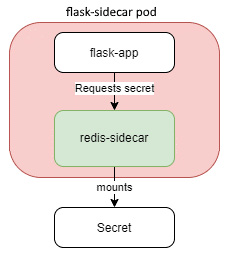

**Implementemos el patrón anterior para comprender mejor un sidecar.** 

- Entonces, tenemos una aplicación Flask que interactúa con un sidecar de Redis. 

**Rellenaremos previamente el sidecar de Redis con un secreto, foobar y lo haremos mediante el uso del recurso secreto de Kubernetes.**



### Secretos
**Los secretos son muy similar a los mapas de configuración, con la diferencia de que los valores secretos están codificados en base64 en lugar de texto plano.** 

Si bien la codificación **base64** no hace ninguna diferencia, y es tan mala como la de **texto plano** desde el punto de vista de la seguridad, deben usar secretos para información confidencial, como contraseñas. 
- Esto se debe a que la comunidad de Kubernetes desarrollará una solución para reforzar la seguridad en torno a los secretos en versiones futuras. 

**Tip Pro.**
Como regla general, utilice siempre secretos para datos confidenciales, como claves y contraseñas de API, y mapas de configuración para datos de configuración no confidenciales.

**Pasemos ahora a la aplicación Flask de ejemplo.**

### Ejemplo de aplicación
**La aplicación de flask consulta un sidecar de Redis por el secreto y lo envía como respuesta.** 

- Eso no es ideal ya que no enviará secretos como respuesta, pero para la demostración, hagámoslo.

**01 | Entonces, primero diseñemos nuestro sidecar para completar previamente los datos dentro del contenedor después de que comience.**

Necesitamos crear un secreto llamado **secret** con el valor **foobar**. Ahora codifique en **base64** el comando Redis para establecer el secreto en el caché.

In [ ]:

$ echo 'SET secret foobar' | base64


**02 | Como ahora tenemos el secreto codificado en base64, podemos crear un manifiesto redis-secret.yaml con la cadena.**



In [ ]:

apiVersion: v1
kind: Secret
metadata:
  name: redis-secret
data:
  redis-secret: U0VUIHNlY3JldCBmb29iYXIK
    

**03 | Luego, debemos construir el contenedor Redis de manera que este secreto se cree al inicio.** 

Para ello, creamos un archivo **entrypoint.sh**.

In [ ]:

redis-server --daemonize yes && sleep 5
redis-cli < /redis-master/init.redis
redis-cli save
redis-cli shutdown
redis-server


El script de shell busca un archivo **init.redis** dentro del directorio **/redis-master** y ejecuta el comando **redis-cli**en él. 

Esto significa que la memoria caché se completará previamente con los valores quevhemos definido en nuestro secreto, siempre que montemos el secreto como **/redis-master/init.redis**.

**04 | Luego creamos un Dockerfilecque usará este script entrypoint.sh de la siguiente manera.**

In [ ]:

FROM redis
COPY entrypoint.sh /tmp/
CMD ["sh", "/tmp/entrypoint.sh"]


**05 | Bien, ahora que estamos listos, podemos compilar y enviar el código a Docker Hub.**



In [ ]:

$ docker build -t <usuario_dockerhub>/redis-secret .
$ docker push <usuario_dockerhub>/redis-secret


Ahora que estamos listos con la imagen de Redis, debemos crear la imagen de la aplicación.

**06 | Veamos primero el archivo app.py.**



In [ ]:

import time
import redis
from flask import Flask
from datetime import datetime
app = Flask(__name__)
cache = redis.Redis(host='localhost', port=6379)
def get_secret():
    try:
        secret = cache.get('secret')
        return secret
    except redis.exceptions.ConnectionError as e:
        raise e
@app.route('/')
def index():
    secret = str(get_secret().decode('utf-8'))
    return 'Hi there! The secret is {}.\n'.format(secret)


**Esto es similar al ejemplo anterior, con la diferencia de que esta vez obtiene el secreto del caché y lo devuelve en la respuesta.**

**El archivo requirements.txt es el siguiente.**


flask
redis


**07 | Luego creamos el siguiente Dockerfile.**



In [ ]:

FROM python:3.7-alpine
ENV FLASK_APP=app.py
ENV FLASK_RUN_HOST=0.0.0.0
RUN apk add --no-cache gcc musl-dev linux-headers
COPY requirements.txt requirements.txt
RUN pip install -r requirements.txt
EXPOSE 5000
COPY . .
CMD ["flask", "run"]


**08 | Entonces, construyamos y envíemos la imagen del contenedor a Docker Hub**



In [ ]:

$ docker build -t <usuario_dockerhub>/flask-redis-secret .
$ docker push <usuario_dockerhub>/flask-redis-secret


OK, así es como nuestras imágenes son ahora, listo. 

**09 | Veamos el manifiesto del pod flask-sidecar.yaml.**



In [ ]:

...
spec:
  containers:
  - name: flask-app
    image: <usuario_dockerhub>/flask-redis-secret
  - name: redis-sidecar
    image: <usuario_dockerhub>/redis-secret
    volumeMounts:
    - mountPath: /redis-master
      name: secret
  volumes:
  - name: secret
    secret:
      secretName: redis-secret
      items:
      - key: redis-secret
        path: init.redis


**El pod define dos contenedores: flask-app y redis-sidecar.** 

Ejecuta la aplicación Flask **flask-app** con la que interactuaría **redis-sidecar** para obtener el secreto. 

- El redis-sidecar ha montado el volumen **secret** en **/redis-master**. 
- La definición del pod también contiene un solo volumen llamado **secret**, y el volumen apunta al secreto **redis-secret** y lo monta como un archivo, **init.redis**.

Entonces, al final, tenemos un archivo, **/redis-master/init.redis** y como sabemos, la secuencia de comandos **entrypoint.sh** busca este archivo y ejecuta el comando **redis-cli** para completar previamente el caché de Redis con los datos secretos.

**10 | Primero apliquemos el secreto con el siguiente comando.**

In [ ]:

$ kubectl apply -f redis-secret.yaml


**11 | Y luego aplique el archivo flask-sidecar.yaml**



In [ ]:

$ kubectl apply -f flask-sidecar.yaml


**12 | Ahora, obtengamos el pod**




$ kubectl get pod flask-sidecar


**13 | Y mientras el pod se está ejecutando, es hora de reenviarlo al host**



In [ ]:

$ kubectl port-forward flask-sidecar 5000:5000


**14 | Ahora, abramos un terminal duplicado, ejecutemos el comando curl localhost:5000 y veamos qué obtenemos.**




$ curl localhost:5000


**Y como vemos, obtenemos el secreto foobar, en la respuesta.** 

¡El sidecar funciona correctamente!

**Veamos ahora otro patrón popular de cápsulas(pods) de varios contenedores: el patrón de adaptador.**

### Patrón adaptador
**Como sugiere el nombre, el patrón de adaptador ayuda a cambiar algo para que se ajuste a un estándar, similar a los adaptadores de teléfonos celulares y computadoras portátiles que convierten nuestra fuente de alimentación principal en algo que nuestros dispositivos pueden digerir.** 

Un gran ejemplo de un patrón de adaptador es la transformación de archivos de registro para que se ajusten a un estándar empresarial para alimentar su solución de análisis de registros.

**Patrón adaptador**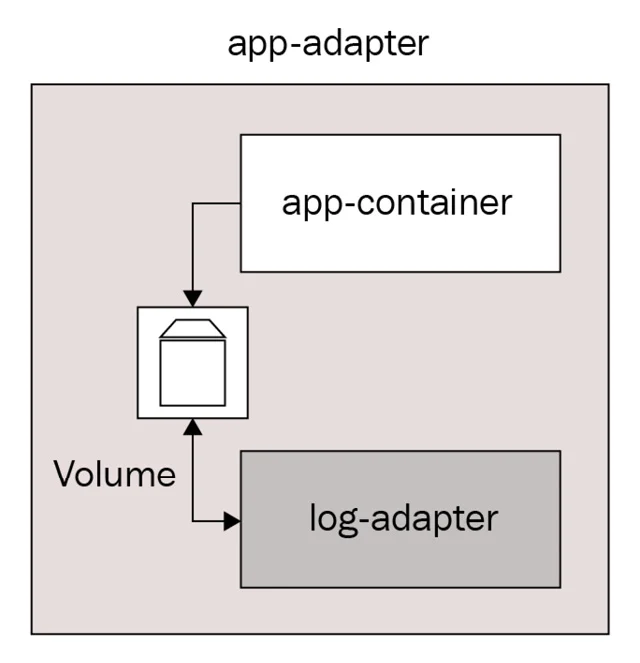

**Ayuda cuando tiene una solución heterogénea que genera archivos de registro en varios formatos, pero una única solución de análisis de registros que acepta mensajes solo en un formato particular.** 

- Habría dos formas de hacerlo: cambiar el código para generar archivos de registro en un formato estándar o usar un contenedor de adaptador para ejecutar la transformación.

**Veamos el siguiente escenario para entenderlo mejor.**

Tenemos una aplicación que genera continuamente archivos de registro, pero sin tener una fecha de inicio. Nuestro adaptador debe leer el flujo de registros y agregar la marca de tiempo tan pronto como se genere una línea de registro.

**01 | Entonces, usamos el manifiesto de pod app-adapter.yaml**

In [ ]:

...
spec:
  volumes:
  - name: logs
    emptyDir: {}
  containers:
  - name: app-container
    image: ubuntu
    command: ["/bin/bash"]
    args: ["-c", "while true; do echo 'This is a log line' >> /var/log/app.log; sleep 2;done"]
    volumeMounts:
    - name: logs
      mountPath: /var/log
  - name: log-adapter
    image: ubuntu
    command: ["/bin/bash"]
    args: ["-c", "apt update -y && apt install -y moreutils && tail -f /var/log/app.log | ts '[%Y-%m-%d %H:%M:%S]' > /var/log/out.log"]
    volumeMounts:
    - name: logs
      mountPath: /var/log



**El manifiesto contiene dos contenedores.** 

El **app-container**, que es un contenedor de Ubuntu simple que genera una salida This is a log line cada 2 segundos, y el **log-adapter**, que rastrea continuamente el archivo **app.log**, agrega una marca de tiempo al comienzo de la línea y envía la salida resultante a **/var/log/out.log.** 
- Ambos contenedores comparten el volumen **/var/log** que está montado como volumen **emptyDir** en ambos contenedores.

**02 | Ahora, apliquemos este manifiesto usando el siguiente comando**

In [ ]:

$ kubectl apply -f app-adapter.yaml


**03 | Esperemos un momento y verifiquemos si el pod se está ejecutando.**



In [ ]:

$ kubectl get pod app-adapter

NAME          READY   STATUS    RESTARTS   AGE
app-adapter   2/2     Running   0          8s

**04 | Mientras se ejecuta el pod, ahora podemos obtener un shell en el contenedor del adaptador de registro.**

In [ ]:

$ kubectl exec -it app-adapter -c log-adapter -- bash


**05 | Cuando nos metemos en el shell, podemos ingresar cd al directorio /var/log y listar su contenido.**



In [ ]:

root@app-adapter:/# cd /var/log/ && ls
app.log apt/ dpkg.log out.log


Y como vemos, obtenemos app.log y out.log como dos archivos. 

**06 | Ahora usemos el comando cat para imprimir ambos para ver qué obtenemos.**

Primero, cat al archivo **app.log**

In [ ]:

root@app-adapter:/var/log# cat app.log
    
This is a log line
This is a log line
This is a log line
This is a log line
This is a log line
This is a log line


Y vemos una serie de líneas de registro que se imprimen.

**07 | Ahora, cat al archivo out.log a ver que obtenemos.**

In [ ]:

root@app-adapter:/var/log# cat out.log
[2020-12-28 06:35:25] This is a log line
[2020-12-28 06:35:27] This is a log line
[2020-12-28 06:35:29] This is a log line
[2020-12-28 06:35:31] This is a log line
[2020-12-28 06:35:33] This is a log line
[2020-12-28 06:35:35] This is a log line


**Y vemos marcas de tiempo delante de la línea de registro.** 

Esto significa que el patrón del adaptador está funcionando correctamente. Luego podemos optar por exportar este archivo de registro a nuestra herramienta de análisis de registros.

## Resumen
**Hemos llegado al final de este capítulo crítico.** 

Hemos cubierto suficiente terreno para que comiencen con Kubernetes y comprendan y aprecien las mejores prácticas que lo rodean.

**Comenzamos con Kubernetes y por qué lo necesitamos, y luego discutimos cómo arrancar un clúster de Kubernetes usando Minikube y KinD.** 
- Luego analizamos el recurso de pod y discutimos la creación y administración de pods 
- La resolución de problemas, la garantía de la confiabilidad de su aplicación mediante sondas
- Y los patrones de diseño de varios contenedores para apreciar por qué Kubernetes usa pods en primer lugar en lugar de contenedores.

**Es momento de profundizar en los aspectos avanzados de Kubernetes** 

Donde cubriremos los controladores, los servicios, los ingresos, la administración de una aplicación con estado y las mejores prácticas de la línea de comandos de Kubernetes.

## Preguntas
¿Toda la comunicación con Kubernetes se realiza a través de cuál de los siguientes?
    
    A. Kubelet

    B. servidor API

    C. Etc.

    D. Gerente del Controlador

    E. Programador

¿Cuál de los siguientes es responsable de garantizar que el clúster esté en el estado deseado?
    
    A. Kubelet

    B servidor API

    C. Etc.

    D. Gerente del Controlador

    E. Programador

¿Cuál de los siguientes es responsable de almacenar el estado deseado del clúster?
    
    A. Kubelet

    B. servidor API

    C. Etc.

    D. Gerente del Controlador

    E. Programador

Un pod puede contener más de un contenedor (Verdadero/Falso).
¿Puede usar el reenvío de puertos para cuál de los siguientes casos de uso (son posibles múltiples respuestas)?
    
    A. Para solucionar problemas de un pod que se comporta mal

    B. Por exponer un servicio a internet

    C. Para acceder a un servicio del sistema como el panel de control de Kubernetes

¿Usando una combinación de qué dos sondas puede asegurarse de que su aplicación sea confiable incluso cuando su aplicación tiene algunos problemas intermitentes (elija dos)?
    
    A. Sonda de inicio

    B. Sonda de vida

    C. Sonda de preparación

Podemos usar KinD en producción (Verdadero/Falso).
¿Cuál de los siguientes patrones de varios contenedores se utiliza como proxy de reenvío?
    
    A. Embajador

    B. adaptador

    C. Sidecar

    D. Contenedores de inicialización

## Respuestas
    B
    D
    C
    Verdadero
    A, C
    ANTES DE CRISTO
    Falso
    A